# **Now calibrate the qubit excitations to state |2>**

## 1st Part: Calibrate Driving Frequency

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from qiskit.tools.jupyter import *
from qiskit import IBMQ, execute
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.pulse import library as pulse_lib
from qiskit.tools.monitor import job_monitor

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
provider = IBMQ.load_account()
backend = provider.get_backend("ibmq_armonk")
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [3]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")

backend_defaults = backend.defaults()

Sampling time: 0.2222222222222222 ns


In [4]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds
# We will find the qubit frequency for the following qubit.
qubit = 0
# We will define memory slot channel 0.
mem_slot = 0

In [5]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of_16(sec/dt)

In [7]:
rough_qubit_frequency = 4.97176 * GHz
pi_amp = 0.05098627672979268
pi_duration = 2480

In [8]:
# The sweep will be centered around the estimated qubit frequency.
# center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
center_frequency_Hz = 4.62 * GHz
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

Qubit 0 has an estimated frequency of 4.62 GHz.


In [9]:
frequency_span_Hz = 20 * MHz
frequency_step_Hz = np.round(frequency_span_Hz / 100, 3) #(1/4) * MHz

In [10]:
# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

In [11]:
pulse_sigma = get_dt_from(0.05 * us)
pulse_duration = 8 * pulse_sigma
pulse_amp = 0.75 # max 1.

In [12]:
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment="sequential", name="base_schedule") as schedule:
    pulse.set_frequency(rough_qubit_frequency, pulse.drive_channel(qubit))
    pulse.play(
        pulse_lib.Constant(
            duration=pi_duration,
            amp=pi_amp,
            name="pi_pulse_01"
        ),
        pulse.drive_channel(qubit)
    )
    pulse.set_frequency(freq, pulse.drive_channel(qubit))
    pulse.play(
        pulse_lib.Gaussian(
            duration=pulse_duration,
            sigma=pulse_sigma,
            amp=pulse_amp,
            name="gauss_pulse"
        ),
        pulse.drive_channel(qubit)
    )
    pulse.measure(
        qubits=[qubit],
        registers=[pulse.MemorySlot(mem_slot)]
    )

In [13]:
frequencies_Hz = frequencies_GHz*GHz
schedules = [
    schedule.assign_parameters(
        {freq: f},
        inplace=False
    ) for f in frequencies_Hz
]

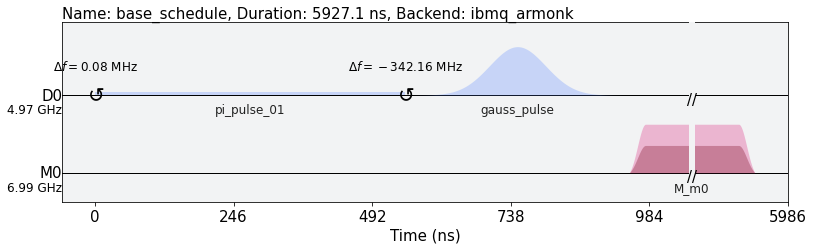

In [14]:
schedules[-2].draw(backend=backend)

In [15]:
num_schedules = len(schedules)
num_shots = 2048


In [16]:
job = execute(
    schedules,
    backend=backend,
    meas_level=1,
    meas_return='avg',
    shots=num_shots
)
job_monitor(job)


Job Status: job has successfully run


In [17]:
result = job.result()

In [18]:
measured_signals = []
for i in range(num_schedules):
    # Get the results from the ith experiment
    results = result.get_memory(i) * 1e-14
    # Get the results for `qubit` from this experiment
    measured_signals.append(results[qubit])
measured_signals = np.array(measured_signals)


In [19]:
job_id = job.job_id()
print("JobID:", job_id)

JobID: 629875b31e5d5ef374df65dd


In [20]:
# print("measured_signals =", measured_signals)

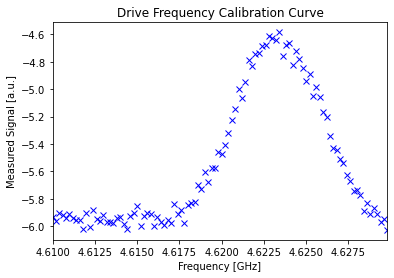

In [21]:
plt.figure(1)
plt.plot(frequencies_GHz, np.real(measured_signals), 'bx') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.title("Drive Frequency Calibration Curve")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [22]:
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)#, maxfev=100000)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(measured_signals), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [0.3, 4.6235, 0.2, -5.9] # initial parameters for curve_fit
                                )

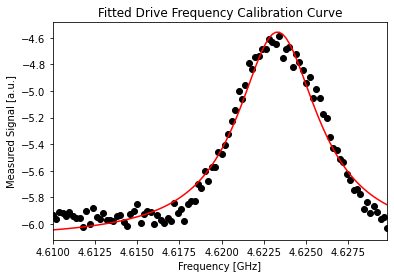

In [23]:
plt.figure(2)
plt.scatter(frequencies_GHz, np.real(measured_signals), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.title("Fitted Drive Frequency Calibration Curve")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
# plt.savefig(os.path.join(save_dir, date.strftime("%H%M%S") + f"_{pulse_type}_frequency_sweep_fitted.png"))
plt.show()


In [24]:
A, rough_qubit_frequency_12, B, C = fit_params
rough_qubit_frequency_12 = rough_qubit_frequency_12*GHz # make sure qubit freq is in Hz
print(f"We've updated our 1->2 qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency_12/GHz, 5)} GHz.")

We've updated our 1->2 qubit frequency estimate from 4.97168 GHz to 4.6233 GHz.


## 2nd part: Calibrate Pulse Area

In [25]:
rabi_pulse_duration = .55
min_amplitude, max_amplitude = 0.001, 0.65
rabi_num_exp = 100
amplitudes = np.linspace(
    min_amplitude, 
    max_amplitude, 
    rabi_num_exp
)
rabi_pulse_duration = get_dt_from(rabi_pulse_duration * us)


In [26]:
amp = Parameter('amp')
with pulse.build(backend=backend, default_alignment="sequential", name="base_schedule") as rabi_schedule:
    pulse.set_frequency(rough_qubit_frequency, pulse.drive_channel(qubit))
    pulse.play(
        pulse_lib.Constant(
            duration=pi_duration,
            amp=pi_amp,
            name="pi_pulse_01"
        ),
        pulse.drive_channel(qubit)
    )
    pulse.set_frequency(rough_qubit_frequency_12, pulse.drive_channel(qubit))
    pulse.play(
        pulse_lib.Constant(
            duration=rabi_pulse_duration,
            amp=amp,
            name="rect_pulse"
        ),
        pulse.drive_channel(qubit)
    )
    pulse.measure(
        qubits=[qubit],
        registers=[pulse.MemorySlot(mem_slot)]
    )

In [27]:
frequencies_Hz = frequencies_GHz*GHz
rabi_schedules = [
    rabi_schedule.assign_parameters(
        {amp: a},
        inplace=False
    ) for a in amplitudes
]

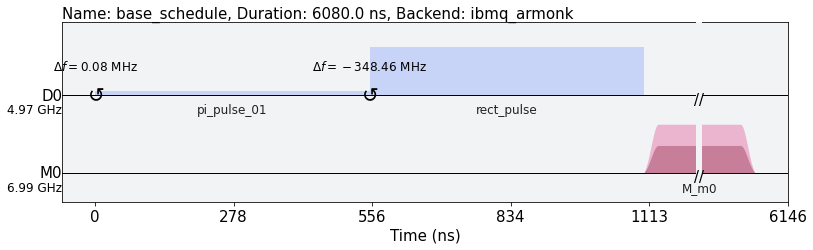

In [28]:
rabi_schedules[-2].draw(backend=backend)

In [29]:
rabi_num_schedules = len(rabi_schedules)
rabi_num_shots = 2048


In [ ]:
rabi_job = execute(
    rabi_schedules,
    backend=backend,
    meas_level=1,
    meas_return='avg',
    shots=rabi_num_shots
)
job_monitor(rabi_job)


Job Status: job is queued (5)     

In [ ]:
rabi_result = rabi_job.result()

In [ ]:
rabi_measured_signals = []
for i in range(rabi_num_schedules):
    # Get the results from the ith experiment
    results = rabi_result.get_memory(i) * 1e-14
    # Get the results for `qubit` from this experiment
    rabi_measured_signals.append(results[qubit])
rabi_measured_signals = np.array(rabi_measured_signals)


In [ ]:
rabi_job_id = rabi_job.job_id()
print("RabiJobID:", rabi_job_id)

In [ ]:
plt.figure(3)
plt.plot(amplitudes, np.real(rabi_measured_signals), 'gx')
plt.xlim([min(amplitudes), max(amplitudes)])
plt.title("Rabi Calibration Curve")
plt.xlabel("Amplitude [a.u.]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [ ]:
fit_crop_parameter = int(0.6 * len(amplitudes))


In [ ]:
rabi_fit_params, rabi_y_fit = fit_function(
    amplitudes[: fit_crop_parameter],
    np.real(rabi_measured_signals[: fit_crop_parameter]), 
    lambda x, A, k, B: A * (np.cos(k * (x))) + B,
    [-2.6, 60, -5.1] # initial parameters for curve_fit
)


In [ ]:
print(rabi_fit_params)
A, k, B = rabi_fit_params
pi_amp_12 = np.pi / (k)
extended_y_fit = A * (np.cos(k * (amplitudes))) + B


In [ ]:
plt.figure(4)
plt.scatter(amplitudes, np.real(rabi_measured_signals), color='black')
plt.plot(amplitudes, extended_y_fit, color='red')
plt.xlim([min(amplitudes), max(amplitudes)])
plt.title("Fitted Rabi Calibration Curve")
plt.xlabel("Amplitude [a.u.]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [ ]:
pi_amp_12

In [ ]:
pi_duration